In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

# import the model architecture
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

#import optimizer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.5.0


In [3]:
# creating the base of the Model - DenseNet121
base_model=DenseNet201(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=base_model.output

# adding activation layers to the model
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
# x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(256,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# output layer for two classes
preds=Dense(2,activation='softmax')(x) #FC-layer

In [4]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block29_concat (Concatena (None, 4, 4, 1824)   0           conv5_block28_concat[0][0]       
                                                                 conv5_block29_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block30_0_bn (BatchNormal (None, 4, 4, 1824)   7296        conv5_block29_concat[0][0]       
__________________________________________________________________________________________________
conv5_block30_0_relu (Activatio (None, 4, 4, 1824)   0           conv5_block30_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block30_1_conv (Conv2D)   (None, 4, 4, 128)    233472      conv5_block30_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_bloc

In [5]:
for layer in model.layers[:-16]:
    layer.trainable=False
    
for layer in model.layers[-32:]:
    layer.trainable=True
    

In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

                                                                 conv4_block41_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block42_0_bn (BatchNormal (None, 8, 8, 1568)   6272        conv4_block41_concat[0][0]       
__________________________________________________________________________________________________
conv4_block42_0_relu (Activatio (None, 8, 8, 1568)   0           conv4_block42_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block42_1_conv (Conv2D)   (None, 8, 8, 128)    200704      conv4_block42_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block42_1_bn (BatchNormal (None, 8, 8, 128)    512         conv4_block42_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_bloc

conv5_block26_2_conv (Conv2D)   (None, 4, 4, 32)     36864       conv5_block26_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block26_concat (Concatena (None, 4, 4, 1728)   0           conv5_block25_concat[0][0]       
                                                                 conv5_block26_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block27_0_bn (BatchNormal (None, 4, 4, 1728)   6912        conv5_block26_concat[0][0]       
__________________________________________________________________________________________________
conv5_block27_0_relu (Activatio (None, 4, 4, 1728)   0           conv5_block27_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block27_1_conv (Conv2D)   (None, 4, 4, 128)    221184      conv5_block27_0_relu[0][0]       
__________

In [7]:
IMG_SIZE = 128

def takeData(DATADIR, CLASSES):
    images = []
    data = []
    for category in CLASSES:
        path_cases = os.path.join(DATADIR, category)
        num_of_cases = len(os.listdir(path_cases))
        for i in range(num_of_cases):
            path_case = os.path.join(path_cases, "{} ({})".format(CLASSES[category], i+1))
            for img in os.listdir(path_case):
                data = np.load(path_case+'/'+img)
                center = len(data)//2
                new_img = data[center]
                new_img_arr = np.array(new_img)
                new_img_arr = resize(new_img_arr, output_shape = (IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
                images.append([new_img_arr, category])
                break
    return images

In [8]:
CLASSES = {"done_non-COVID-19" : 0, "done_COVID-19" : 1}
DATADIR = "data/"

# take the dataset of masked images of COVID and non_COVID cases
data_array = takeData(DATADIR, CLASSES)
# check the number of samples
print(len(data_array)) 

828


In [9]:
random.seed(0)
random.shuffle(data_array)

image_data = []
classes = []
for d in data_array:
    image_data.append(d[0])
    classes.append(d[1])

image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
classes = np.hstack((classes, 1 - classes))

In [10]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(662, 128, 128, 3) (166, 128, 128, 3)


In [13]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
                    steps_per_epoch=xtrain.shape[0] //128,
                    epochs=80,
                    verbose=2,
                    callbacks=[anne, checkpoint],
                    validation_data=(xtrain, ytrain))

Epoch 1/80
5/5 - 6s - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0562 - val_accuracy: 0.9728

Epoch 00001: val_loss improved from inf to 0.05616, saving model to model.h5
Epoch 2/80
5/5 - 6s - loss: 0.0506 - accuracy: 0.9813 - val_loss: 0.0343 - val_accuracy: 0.9834

Epoch 00002: val_loss improved from 0.05616 to 0.03435, saving model to model.h5
Epoch 3/80
5/5 - 8s - loss: 0.0259 - accuracy: 0.9869 - val_loss: 0.0274 - val_accuracy: 0.9940

Epoch 00003: val_loss improved from 0.03435 to 0.02744, saving model to model.h5
Epoch 4/80
5/5 - 6s - loss: 0.0255 - accuracy: 0.9906 - val_loss: 0.0247 - val_accuracy: 0.9970

Epoch 00004: val_loss improved from 0.02744 to 0.02467, saving model to model.h5
Epoch 5/80
5/5 - 7s - loss: 0.0300 - accuracy: 0.9925 - val_loss: 0.0347 - val_accuracy: 0.9879

Epoch 00005: val_loss did not improve from 0.02467
Epoch 6/80
5/5 - 10s - loss: 0.0343 - accuracy: 0.9869 - val_loss: 0.0399 - val_accuracy: 0.9864

Epoch 00006: val_loss did not improve from 0.0

5/5 - 15s - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0545 - val_accuracy: 0.9653

Epoch 00054: val_loss did not improve from 0.01343
Epoch 55/80
5/5 - 13s - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0524 - val_accuracy: 0.9698

Epoch 00055: val_loss did not improve from 0.01343
Epoch 56/80
5/5 - 15s - loss: 0.0144 - accuracy: 0.9925 - val_loss: 0.0563 - val_accuracy: 0.9743

Epoch 00056: val_loss did not improve from 0.01343
Epoch 57/80
5/5 - 15s - loss: 0.0138 - accuracy: 0.9925 - val_loss: 0.0634 - val_accuracy: 0.9728

Epoch 00057: val_loss did not improve from 0.01343
Epoch 58/80
5/5 - 16s - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.1810 - val_accuracy: 0.9411

Epoch 00058: val_loss did not improve from 0.01343
Epoch 59/80
5/5 - 15s - loss: 0.0585 - accuracy: 0.9766 - val_loss: 0.0446 - val_accuracy: 0.9789

Epoch 00059: val_loss did not improve from 0.01343
Epoch 60/80
5/5 - 15s - loss: 0.0492 - accuracy: 0.9850 - val_loss: 0.0698 - val_accuracy: 0.9773

Epoch 00060: 

In [14]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')
print(np.argmax(ypred[5]))

Total-test-data; 166 	accurately-predicted-data: 132 	 wrongly-predicted-data:  34
Accuracy: 79.518 %
0


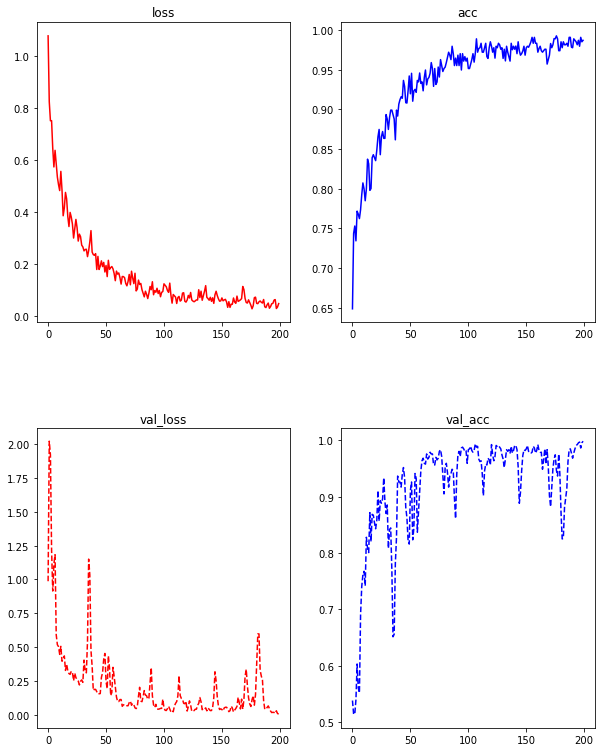

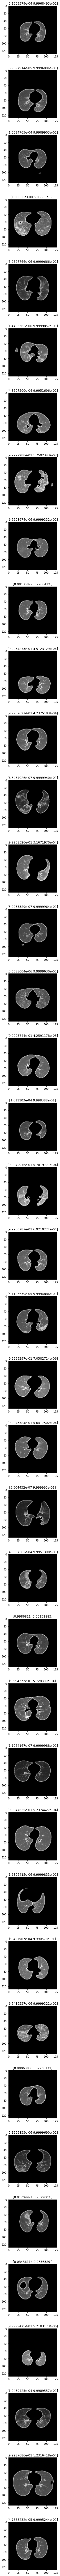

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')

preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze())
    ax1[i].title.set_text(str(preds[i]))

IndexError: list index out of range

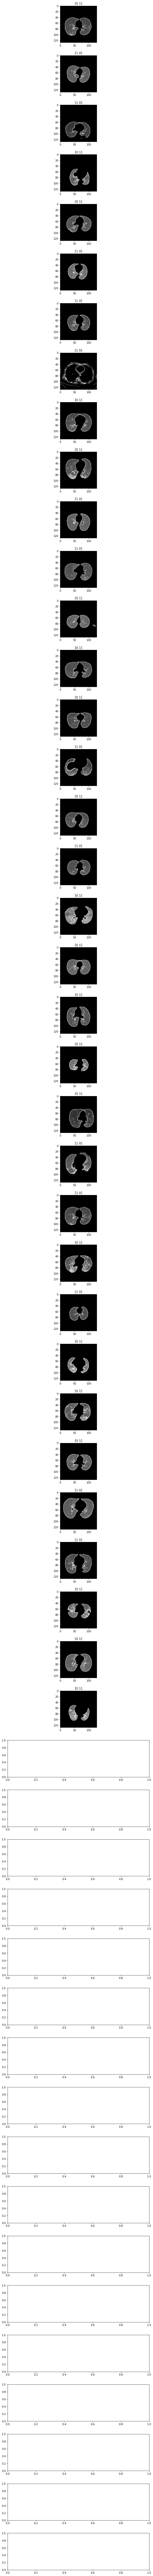

In [15]:
fig1, ax1 = plt.subplots(52, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)
wrongindex
for i in range(52):
    ax1[i].imshow(xtest[wrongindex[i]].squeeze())
    ax1[i].title.set_text(str(ytest[i]))
    
